# Sea Level Trend     
 
```{glue:figure} trend_fig
:scale: 25%
:align: right
```
In this notebook, we'll be creating a [table](create-a-table), a [map](fig-mag), and a time series [plot](trend_fig) of absolute and regional sea level change at Hawaiian Islands tide gauge stations from 1993-2024. Absolute sea level, typically measured by satellite altimetry, refers to the height of the sea surface relative to a reference ellipsoid. Here, we'll use the global ocean gridded L4 Sea Level Anomalies (SLA) available from Copernicus {cite:t}`cmemsDUACS`, which is the sea surface height (SSH) minus the mean sea surface (MSS), where the MSS is the temporal mean of SSH over a given period. Relative sea level is measured by a tide gauge, and is the sea level relative to land at that location. Differences between the two measurements can arise from vertical land motion, regional oceanographic conditions like currents, and changes to the gravitational field (affecting the geoid). 

```{caution}
Note: Gridded sea level anomalies are available through Nov 2024 at the moment at the time of this notebook compilation. 
```

Download Files:
[Map](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_magnitude_map_Hawaii.png) |
[Time Series Plot](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_magnitude_timeseries.png) |
[Table](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_magnitude_results_Hawaii.csv)

## Setup

We'll run our initial setup for libraries, plotting, and directories.

In [1]:
%run ../setup.ipynb  


## Retrieve Data Sources

Please see the Data Wrangling notebook, where we source everything from UHSLC or NOAA CO-OPS and CMEMS. In this notebook, we saved three xarray datasets: a sea level altimetry product for the area around the Hawaiian Islands (asl_hawaii.nc), an hourly tide gauge record for the stations in that region (rsl_hawaii.nc), and a de-meaned daily average tide gauge record (rsl_daily_hawaii.nc).


In [2]:
# Next, let's establish a period of record from 1993-2024.
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2024,11,19)

# Normalize the data relative to the 1993-2012 epoch
epoch_start, epoch_end = start_date, '2012-12-31'
#
# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# glue these variables
glue("start_date",start_date)
glue("end_date",end_date)
glue("start_date_str",start_date_str)
glue("end_date_str",end_date_str)
glue("station_group",'Hawaiian Islands')

datetime.datetime(1993, 1, 1, 0, 0)

datetime.datetime(2024, 11, 19, 0, 0)

'1993-01-01'

'2024-11-19'

'Hawaiian Islands'

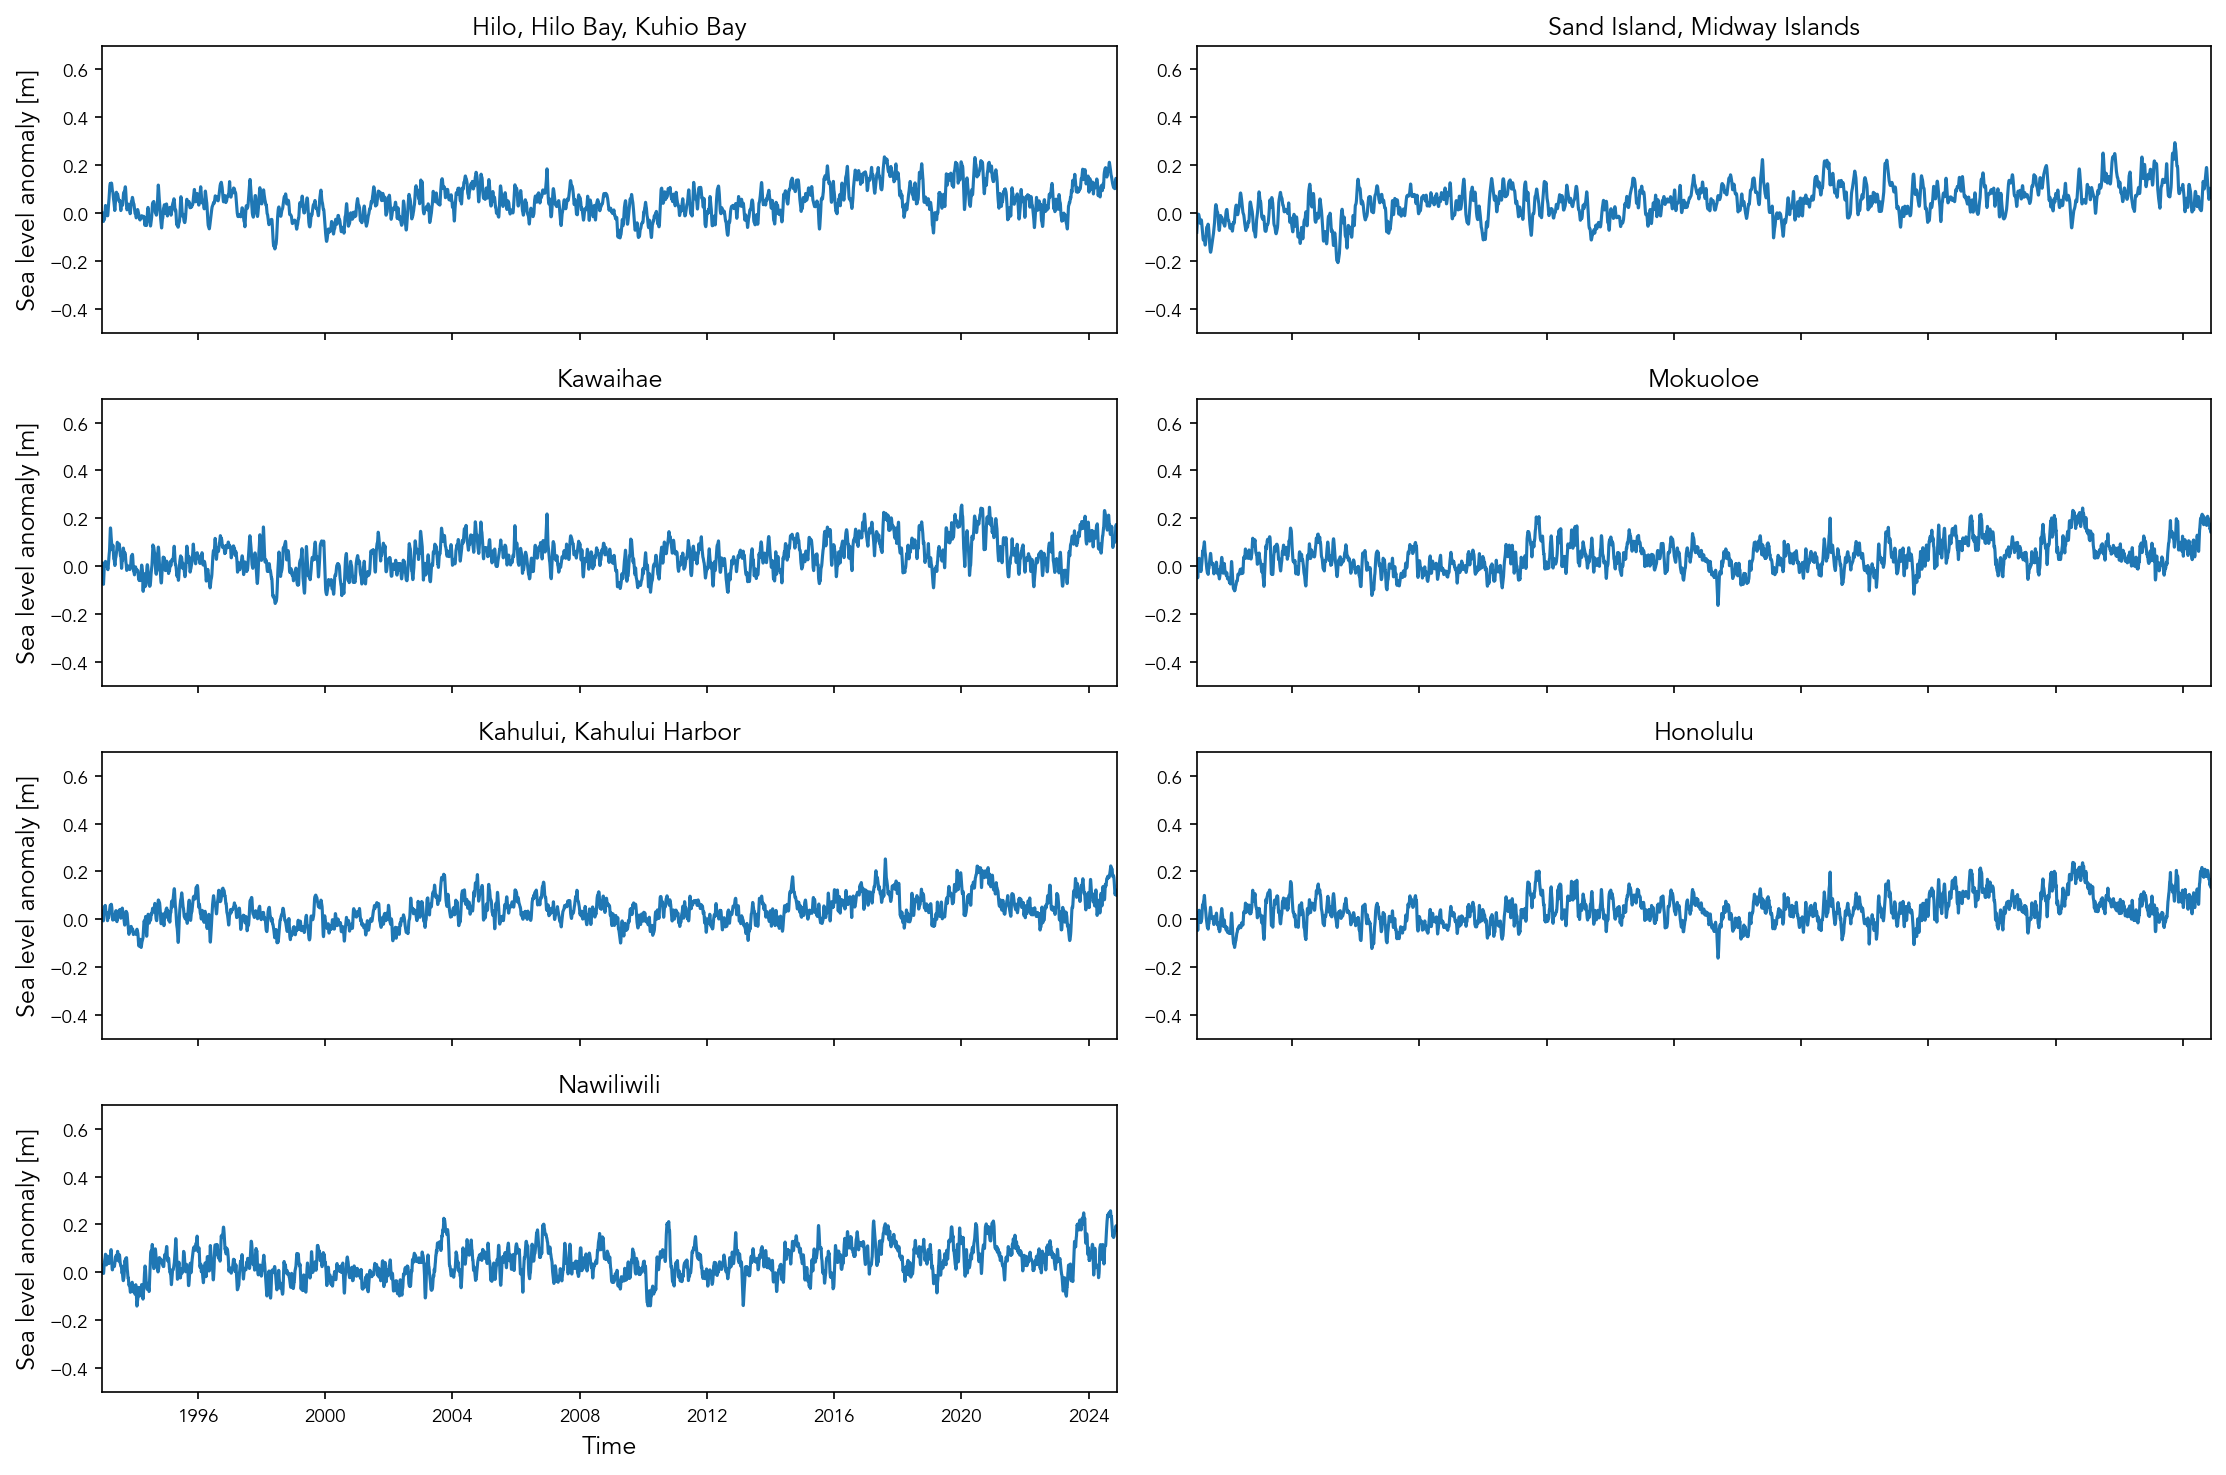

In [3]:
#import datasets
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_hawaii.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_hawaii.nc')
sla = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc')


g = sla_tg.sla.plot(x='time', col='station_id', col_wrap=2, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, sid in zip(g.axs.flat, sla_tg.station_id):
    # Accessing the station_name coordinate for the current station_id directly
    station_name = sla_tg.station_name.sel(station_id=sid).item()
    ax.set_title(station_name)
    ax.set_ylim(-0.5, 0.7)
    ax.set_xlim(start_date, end_date)

# glue the figure
glue("fig:sla_tg", g, display=False)



```{glue:figure} fig:sla_tg
:name: "fig:sla_tg"

Taking a quick glance at the absolute sea level anomaly timeseries near the tide gauges.
```

First we'll truncate the data to the period of record

In [4]:
sla_epoch = sla_tg.sel(time=slice(epoch_start, epoch_end))

# #print('Number of NaN values in the tide gauge data: ', tide_gauge_data_POR.isnull().sum().values)
#Run a quick check to see if the Ab SL from CMEMS is in fact zeroed about the 1993-2012 epoch, with bias to make 1993 zero. We expect numbers near 2.5cm.
print('The mean for the [1993,2012] epoch of the SLA is', sla_epoch.sla.mean(dim='time', skipna=True).values, 'm. Re-check source data to make sure this is correct.')

The mean for the [1993,2012] epoch of the SLA is [0.02741762 0.0254514  0.02320953 0.02493101 0.02353344 0.02480464
 0.02581168] m. Re-check source data to make sure this is correct.


```{margin} Why is the mean of the Sea Level Anomaly from altimetry not zero?
The mean is not zero even when using the correct 20-year reference period, because the altimetry products use 1993 as a reference year. This means that the anomaly for 1993 is zero instead of the middle of the 20-year reference period. The resulting mean (around 2.5 cm without any corrections for Glacial Isostatic Adjustment(GIA)) of the 20-year reference period is the result of global sea level rise.
```


### Plot the timeseries
Here, we'll plot the time series of the altimetry data at the nearest location to the tide gauge (aka 'sla_tg'). The units of sla_tg are in meters, so we'll multiply by 100 to plot in centimeters.


Text(0.5, 1.0, 'Altimetry (1993-2024)')

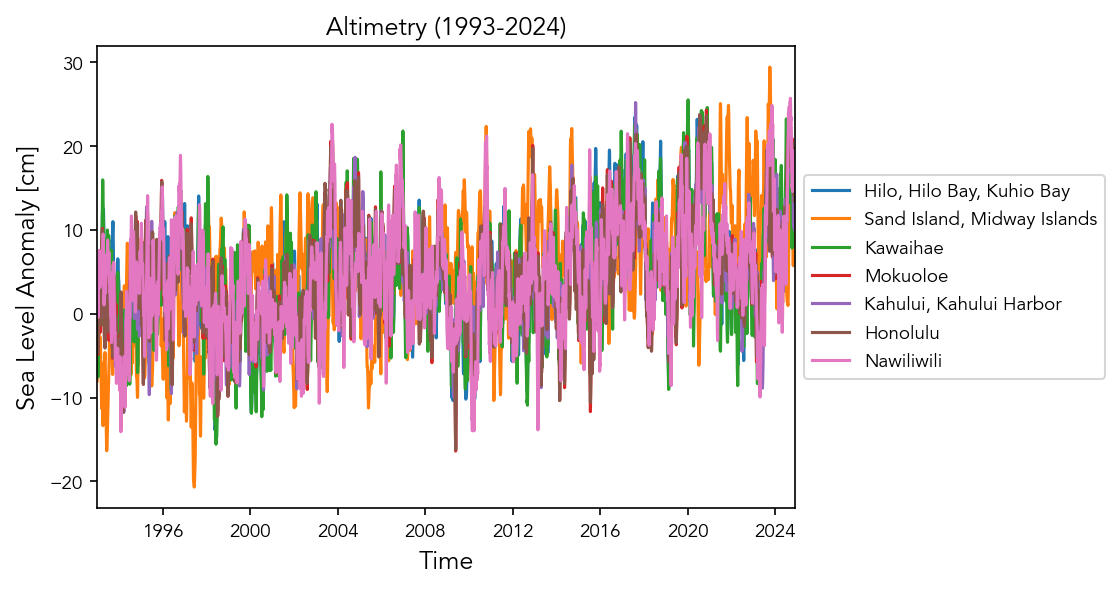

In [5]:
#make a new variable in sla_tg for cm instead of m
sla_tg['sla_cm'] = sla_tg['sla']*100
sla_tg['sla_cm'].attrs['units'] = 'cm'
sla_tg['sla_cm'].attrs['long_name'] = 'Sea Level Anomaly'

#plot the timeseries in sla_tg

sla_tg['sla_cm'].plot.line(x='time',label=sla_tg.station_name.values)

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set xlimits
plt.xlim([start_date, end_date])

# set title 
plt.title('Altimetry (1993-2024)')

### Calculate change
Now we have all of our data sources, we'll calculate the absolute and relative sea level change (magnitude in cm) at this location for the Period of Record (1993-2024).

To do this, we'll first define a function that calculates the sea level change magnitude.

In [6]:

def process_trend_spatial(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    trend_mag_flat = np.full(sla_flat.shape[1], fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept
            trend_mag_flat[i] = trend[-1] - trend[0]

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)
    trend_mag = trend_mag_flat.reshape(sea_level_anomaly.shape[1:])

    # Return in same type as input
    if isinstance(sea_level_anomaly, xr.DataArray):
        trend_mag = xr.DataArray(
            trend_mag,
            dims=sea_level_anomaly.dims[1:],
            coords={dim: sea_level_anomaly.coords[dim] for dim in sea_level_anomaly.dims[1:]}
        )
        detrended = xr.DataArray(
            detrended,
            dims=sea_level_anomaly.dims,
            coords={dim: sea_level_anomaly.coords[dim] for dim in sea_level_anomaly.dims}
        )


    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  


Now we'll run that function for every grid point in our dataset, and make special variables for our proxy tide gauge location.
Warning: This might take a while!!!


In [7]:
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = tsf.process_trend_with_nan(sla.sla)


Processing xarray DataArray (vectorized polyfit, time in years)...


In [8]:
trend_mag_asl, trend_line_asl, trend_rate_asl = tsf.process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)


Processing xarray DataArray (vectorized polyfit, time in years)...


Calculate the weighted mean for the region of interest. 

In [9]:
# calculate the area weights as cosine of latitude
# For a rectangular grid, this is equivalent to multiplying by the grid cell area
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"

# apply weights to the trend data
trend_mag_weighted = trend_mag_cmems.weighted(weights)

# calculate the regional mean
trend_mag_regional = trend_mag_weighted.mean(dim=('latitude', 'longitude'))

# prepare the output string
output = (
    'The regional magnitude of sea level change is {:.2f} cm for the time '
    'period bounded by {} and {}.'
).format(100*trend_mag_regional.values, start_date_str, end_date_str)

print(output)

The regional magnitude of sea level change is 10.32 cm for the time period bounded by 1993-01-01 and 2024-11-19.


### Plot a map
Plot the Results – MAP

Using central_longitude=180 for projection


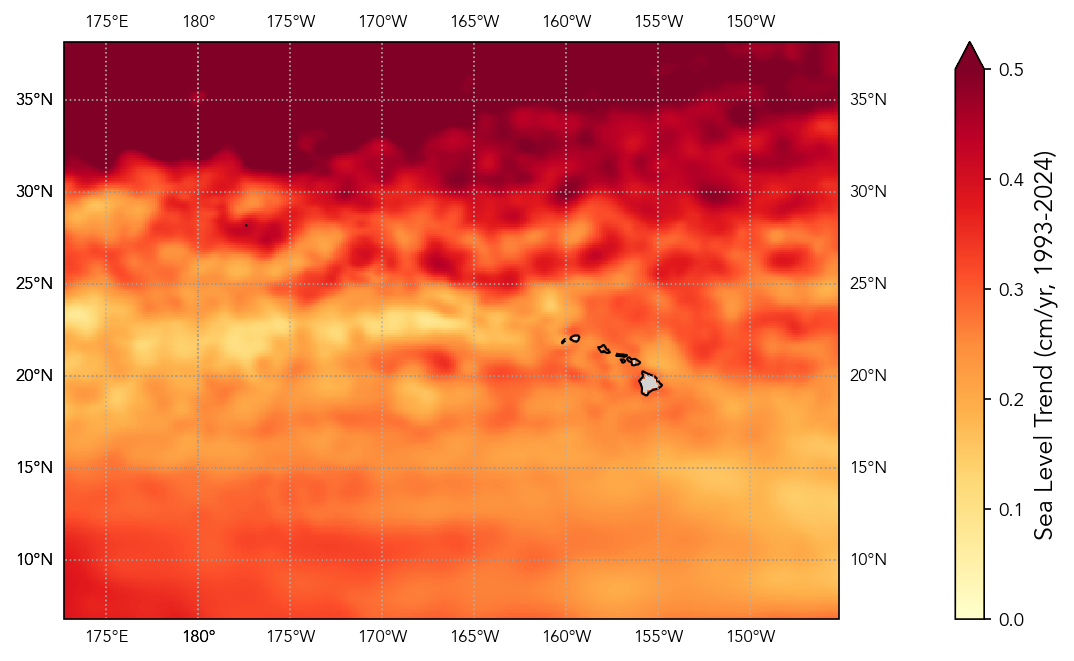

In [10]:
minlon,maxlon = sla.longitude.min().values, sla.longitude.max().values
minlat,maxlat = sla.latitude.min().values, sla.latitude.max().values

xlims = [minlon, maxlon]
ylims = [minlat,maxlat]
vmin, vmax = 0,0.5
cmap = sns.palettes.color_palette('YlOrRd', as_cmap=True)

fig, ax, crs = pf.plot_map(vmin,vmax,cmap,xlims,ylims)

# plot the trend*100 for centimeters
trend_rate_cmems_cm = trend_rate_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_rate_cmems_cm.plot(ax=ax, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, add_labels=False,
                         cbar_kwargs={'label': 'Sea Level Trend (cm/yr, 1993-2024)','pad': 0.1},
)

# add gridlines
# Add gridlines and ticks
latlondx = [5,10]
lon_ticks = np.arange(-180, 181, latlondx[0])  # Every 20° from -180 to 180
lat_ticks = np.arange(-90, 91, latlondx[0])  # Every 10° from -90 to 90
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle=':')
gl.xlocator = plt.FixedLocator(lon_ticks)  # Set longitude tick locations
gl.ylocator = plt.FixedLocator(lat_ticks)  # Set latitude tick locations    
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


# add a dot for the tide gauge location
# ax.scatter(rsl_daily['lon'], rsl_daily['lat'], marker='o', color='cyan', transform=ccrs.PlateCarree(), s=10, label='Tide Gauge',zorder=5)
# add text label for each station name in rsl_daily
# rsl_daily_df = rsl_daily.to_dataframe().reset_index()
# for _, row in rsl_daily_df.iterrows():
#     ax.text(row['lon'] + 0.5, row['lat'] - 0.5, row['station_name'], transform=ccrs.PlateCarree(), fontsize=8)

# save figure
plt.savefig(output_dir / 'SL_trend_map.png', dpi=300, bbox_inches='tight')

glue("trend_rate_fig", fig, display=False)

```{glue:figure} trend_rate_fig
:name: "trend_rate_fig"

Absolute sea level trend from altimetry over the period {glue:text}`start_date_str` to {glue:text}`end_date_str`.
```

(ASLtimeseries)=
### Plot time series
Now we'll plot a time series that includes a trend line, the Absolute Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s. For now, we'll plot only one station at a time. The possible list of stations are:

In [11]:
#make a dataframe with station_name and record_id
df = pd.DataFrame({'station_name':sla_tg.station_name.values, 'station_id':sla_tg.station_id.values})
df

station_name station_id
0    Hilo, Hilo Bay, Kuhio Bay    1617760
1  Sand Island, Midway Islands    1619910
2                     Kawaihae    1617433
3                     Mokuoloe    1612480
4      Kahului, Kahului Harbor    1615680
5                     Honolulu    1612340
6                   Nawiliwili    1611400

Select which station you'd like to plot here:

In [12]:
# EDIT THIS CELL
stationID = 0

Text(0.95, 0.05, 'Δ Sea Level: 8.93 cm, Trend: 0.28 cm/year')

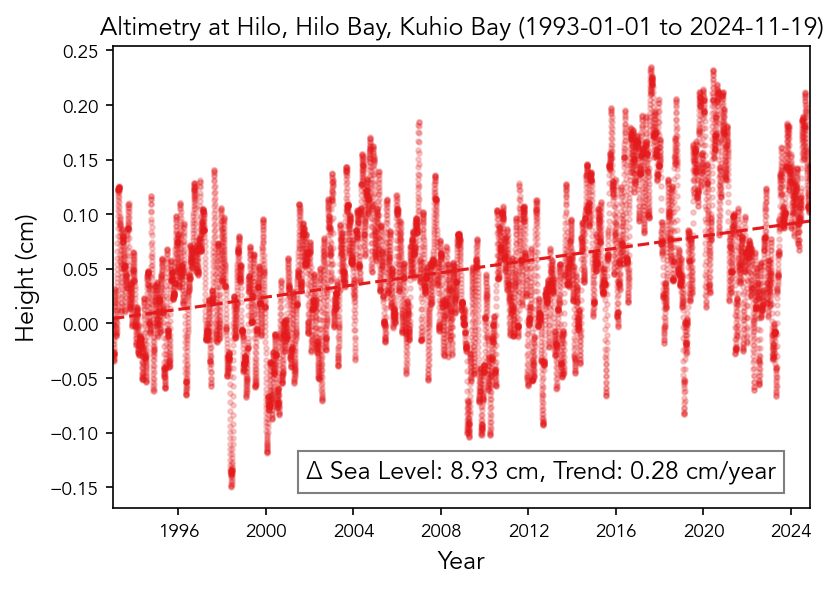

In [13]:
# Set the style of the plot
# sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data from sla_tg, using the first record_id


sla_tg.sla.isel(station_id = stationID).plot.scatter(x='time', label='Altimetry', color=palette[0], alpha=0.2, s=5)
trend_line_asl.isel(station_id = stationID).plot.line(x='time', label='Altimetry Trend', color=palette[0], linestyle='--')


# Set the title and labels
title = f"Altimetry at {sla_tg['station_name'].isel(station_id = stationID).values} ({start_date_str} to {end_date_str})"
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = (f'Δ Sea Level: {100*trend_mag_asl.isel(station_id=stationID):.2f} cm, '
                f'Trend: {100*trend_rate_asl.isel(station_id=stationID):.2f} cm/year')

# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

In [14]:
rsl_daily

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11688)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    latitude      (station_id) float32 28B ...
    longitude     (station_id) float32 28B ...
    lat           (station_id) float64 56B ...
    lon           (station_id) float64 56B ...
    station_name  (station_id) <U27 756B ...
    storm_time    (time) datetime64[ns] 94kB ...
Data variables:
    rsl_anomaly   (station_id, time) float64 655kB ...
    rsl_mhhw      (station_id, time) float64 655kB ...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [15]:
# calculate the rate of change for the tide gauge
# trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly)


trend_mag_rsl, trend_line_rsl, trend_rate_rsl = tsf.process_trend_with_nan(rsl_daily.rsl_anomaly)

print(f'The trend magnitude for the tide gauge is {100*trend_mag_rsl.isel(station_id=stationID):.2f} cm.')
print(f'The trend rate for the tide gauge is {100*trend_rate_rsl.isel(station_id=stationID):.2f} cm/year.')


Processing xarray DataArray (vectorized polyfit, time in years)...
The trend magnitude for the tide gauge is 11.79 cm.
The trend rate for the tide gauge is 0.37 cm/year.


(RSLtimeseries)=
### Plot time series
Now we'll combine our daily relative sea level time series, the monthly mean, and a trend line into the same plot. We will label it with the Relative Sea Level Sea Level Change (magnitude in cm) and rate of change (cm/yr) at the Tide Station. The "zero" line is referenced to the [1993,2012] period, following the altimetry. 

Text(0.95, 0.05, 'Δ Sea Level: 11.79 cm, Trend: 0.37 cm/year')

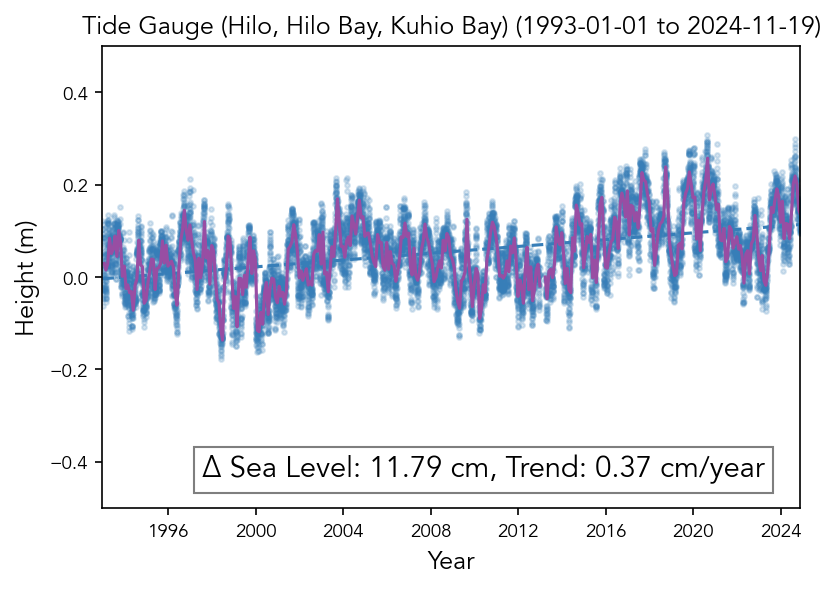

In [16]:
# make an rsl monthly mean for plotting
rsl_monthly = rsl_daily.resample(time='1ME').mean().squeeze()


# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()
# plot data

rsl_daily.rsl_anomaly.isel(station_id=stationID).plot.scatter(x='time', label='Tide Gauge', color=palette[1], alpha=0.2, s=5)
trend_line_rsl.isel(station_id=stationID).plot.line(x='time', label='Tide Gauge Trend', color=palette[1], linestyle='--')

# plot the monthly mean sea level
rsl_monthly.rsl_anomaly.isel(station_id=stationID).plot.line(x='time', label='Tide Gauge', color=palette[3])


# Set the title and labels
ax.set_title(f'Tide Gauge ({rsl_daily.station_name.isel(station_id=stationID).values}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (m)')

# Set the y limits
ax.set_ylim([-.50, .50])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = f'Δ Sea Level: {100*trend_mag_rsl.isel(station_id=stationID):.2f} cm, Trend: {100*trend_rate_rsl.isel(station_id=stationID):.2f} cm/year'
# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))

## Combining both sources

(create-a-table)=
### Create a Table 
That compares the results of sections {numref}`ASLtimeseries` and {numref}`RSLtimeseries`– TABLE

In [17]:

# Constants
DATA_SOURCE_ALTIMETRY = 'CMEMS SSH L4 0.125 deg (SLA)'
DATA_SOURCE_TIDE_GAUGE = 'NOAA COOPS'
TIME_PERIOD = f'{start_date_str} to {end_date_str}'

# Calculated values 
trend_mmyr_altimetry = 1000 * trend_rate_asl.values
trend_mmyr_tide_gauge = 1000 * trend_rate_rsl.values
delta_sea_level_altimetry = 100 * trend_mag_asl.values
delta_sea_level_tide_gauge = 100 * trend_mag_rsl.values

In [18]:
# Initialize DataFrame with station names and calculate UHSLC_ID directly
SL_magnitude_results = (
    pd.DataFrame({
        'Station_Name': sla_tg.station_name.values,
        'Station_ID': rsl_daily['station_id'].values,
        'Trend ASL (mm/yr)': trend_mmyr_altimetry,
        'Trend RSL (mm/yr)': trend_mmyr_tide_gauge,
        'Δ Sea Level ASL (cm)': delta_sea_level_altimetry,
        'Δ Sea Level RSL (cm)': delta_sea_level_tide_gauge,
        'Latitude ASL': sla_tg['latitude'].values,
        'Latitude RSL': rsl_daily['lat'].values,
        'Longitude ASL': sla_tg['longitude'].values,
        'Longitude RSL': rsl_daily['lon'].values,
        'Time_Period': TIME_PERIOD,
        'Data_Source ASL': DATA_SOURCE_ALTIMETRY,
        'Data_Source RSL': DATA_SOURCE_TIDE_GAUGE
    })
)
# if Longitude is greater than 180, subtract 360
SL_magnitude_results['Longitude ASL'] = np.where(SL_magnitude_results['Longitude ASL'] > 180, SL_magnitude_results['Longitude ASL'] - 360, SL_magnitude_results['Longitude ASL'])
SL_magnitude_results['Longitude RSL'] = np.where(SL_magnitude_results['Longitude RSL'] > 180, SL_magnitude_results['Longitude RSL'] - 360, SL_magnitude_results['Longitude RSL'])

SL_magnitude_results




Station_Name Station_ID  Trend ASL (mm/yr)  \
0    Hilo, Hilo Bay, Kuhio Bay    1617760           2.801292   
1  Sand Island, Midway Islands    1619910           4.237172   
2                     Kawaihae    1617433           2.982044   
3                     Mokuoloe    1612480           2.659833   
4      Kahului, Kahului Harbor    1615680           2.697505   
5                     Honolulu    1612340           2.637081   
6                   Nawiliwili    1611400           2.605069   

   Trend RSL (mm/yr)  Δ Sea Level ASL (cm)  Δ Sea Level RSL (cm)  \
0           3.683290              8.931732             11.786276   
1           3.492338             13.509937             11.175241   
2           4.355554              9.508046             13.937475   
3           3.035611              8.480697              9.713746   
4           2.709206              8.600814              8.669274   
5           2.690956              8.408154              8.610875   
6           3.271722              8.306088             10.469286   

   Latitude ASL  Latitude RSL  Longitude ASL  Longitude RSL  \
0       19.6875     19.730278      -155.0625     -155.05556   
1       28.1875     28.211666      -177.3125     -177.36000   
2       20.0625     20.036600      -155.8125     -155.82940   
3       21.4375     21.433056      -157.8125     -157.79000   
4       20.9375     20.894945      -156.4375     -156.46900   
5       21.3125     21.303333      -157.8125     -157.86453   
6       21.9375     21.954400      -159.3125     -159.35610   

                Time_Period               Data_Source ASL Data_Source RSL  
0  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
1  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
2  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
3  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
4  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
5  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
6  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS

In [19]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html

# Create a Table object
table = GT(SL_magnitude_results).tab_spanner('ALTIMETRY', 
                                             columns=['Trend ASL (mm/yr)', 'Δ Sea Level ASL (cm)', 
                                                                   'Latitude ASL', 'Longitude ASL', 'Data_Source ASL']).tab_spanner(
                                                                       'TIDE GAUGE', columns=['Trend RSL (mm/yr)', 'Δ Sea Level RSL (cm)', 'Latitude RSL', 'Longitude RSL', 'Data_Source RSL']).fmt_number(
    decimals=2, columns=['Trend ASL (mm/yr)', 'Trend RSL (mm/yr)', 'Δ Sea Level ASL (cm)', 'Δ Sea Level RSL (cm)', 
                         'Latitude ASL', 'Latitude RSL', 'Longitude ASL', 'Longitude RSL']).tab_source_note(
                             source_note="Data sources: Altimetry, CMEMS SSH L4 0.125 deg (SLA); Tide Gauges, NOAA CO-OPS Hourly").cols_hide(
                                 columns=['Data_Source ASL', 'Data_Source RSL','Time_Period','Station_ID']).cols_label(
                                        Station_Name='Station').tab_options(table_font_size='small')

table

tableHTML = table.as_raw_html(make_page=True)
#save tableHTML to output directory
with open(output_dir / 'SL_magnitude_results.html', 'w') as f:
    f.write(tableHTML)




In [20]:
# save table as png
table.save(output_dir / 'SL_magnitude_results.png')

GT(_tbl_data=                  Station_Name Station_ID  Trend ASL (mm/yr)  \
0    Hilo, Hilo Bay, Kuhio Bay    1617760           2.801292   
1  Sand Island, Midway Islands    1619910           4.237172   
2                     Kawaihae    1617433           2.982044   
3                     Mokuoloe    1612480           2.659833   
4      Kahului, Kahului Harbor    1615680           2.697505   
5                     Honolulu    1612340           2.637081   
6                   Nawiliwili    1611400           2.605069   

   Trend RSL (mm/yr)  Δ Sea Level ASL (cm)  Δ Sea Level RSL (cm)  \
0           3.683290              8.931732             11.786276   
1           3.492338             13.509937             11.175241   
2           4.355554              9.508046             13.937475   
3           3.035611              8.480697              9.713746   
4           2.709206              8.600814              8.669274   
5           2.690956              8.408154              8.610875   
6           3.271722              8.306088             10.469286   

   Latitude ASL  Latitude RSL  Longitude ASL  Longitude RSL  \
0       19.6875     19.730278      -155.0625     -155.05556   
1       28.1875     28.211666      -177.3125     -177.36000   
2       20.0625     20.036600      -155.8125     -155.82940   
3       21.4375     21.433056      -157.8125     -157.79000   
4       20.9375     20.894945      -156.4375     -156.46900   
5       21.3125     21.303333      -157.8125     -157.86453   
6       21.9375     21.954400      -159.3125     -159.35610   

                Time_Period               Data_Source ASL Data_Source RSL  
0  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
1  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
2  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
3  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
4  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
5  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  
6  1993-01-01 to 2024-11-19  CMEMS SSH L4 0.125 deg (SLA)      NOAA COOPS  , _body=<great_tables._gt_data.Body object at 0x31c909890>, _boxhead=Boxhead([ColInfo(var='Station_Name', type=<ColInfoTypeEnum.default: 1>, column_label='Station', column_align='left', column_width=None), ColInfo(var='Station_ID', type=<ColInfoTypeEnum.hidden: 4>, column_label='Station_ID', column_align='right', column_width=None), ColInfo(var='Trend ASL (mm/yr)', type=<ColInfoTypeEnum.default: 1>, column_label='Trend ASL (mm/yr)', column_align='right', column_width=None), ColInfo(var='Δ Sea Level ASL (cm)', type=<ColInfoTypeEnum.default: 1>, column_label='Δ Sea Level ASL (cm)', column_align='right', column_width=None), ColInfo(var='Latitude ASL', type=<ColInfoTypeEnum.default: 1>, column_label='Latitude ASL', column_align='right', column_width=None), ColInfo(var='Longitude ASL', type=<ColInfoTypeEnum.default: 1>, column_label='Longitude ASL', column_align='right', column_width=None), ColInfo(var='Data_Source ASL', type=<ColInfoTypeEnum.hidden: 4>, column_label='Data_Source ASL', column_align='left', column_width=None), ColInfo(var='Trend RSL (mm/yr)', type=<ColInfoTypeEnum.default: 1>, column_label='Trend RSL (mm/yr)', column_align='right', column_width=None), ColInfo(var='Δ Sea Level RSL (cm)', type=<ColInfoTypeEnum.default: 1>, column_label='Δ Sea Level RSL (cm)', column_align='right', column_width=None), ColInfo(var='Latitude RSL', type=<ColInfoTypeEnum.default: 1>, column_label='Latitude RSL', column_align='right', column_width=None), ColInfo(var='Longitude RSL', type=<ColInfoTypeEnum.default: 1>, column_label='Longitude RSL', column_align='right', column_width=None), ColInfo(var='Data_Source RSL', type=<ColInfoTypeEnum.hidden: 4>, column_label='Data_Source RSL', column_align='left', column_width=None), ColInfo(var='Time_Period', type=<ColInfoTypeEnum.hidden: 4>, column_label='Tim

In [21]:
# Save to CSV
output_file_path = output_dir / 'SL_magnitude_results_Hawaii.csv'

# Use the path for operations, e.g., saving a DataFrame
SL_magnitude_results.to_csv(output_file_path)
# glue trend_rates to the notebook
glue("trend_rate_rsl", trend_rate_rsl, display=False)
glue("trend_rate_asl", trend_rate_asl, display=False)



(create-a-map)=
### Create a Map 
Now we'll combine a both the tide gauge and altimetry sources into a map that includes the absolute change with the addition of an icon depicting the magnitude of relative change at the tide station.

In [22]:
trend_mag_rsl
# add lat lon back to trend_mag_rsl from rsl_daily
trend_mag_rsl['lat'] = rsl_daily['lat']
trend_mag_rsl['lon'] = rsl_daily['lon']

Using central_longitude=180 for projection


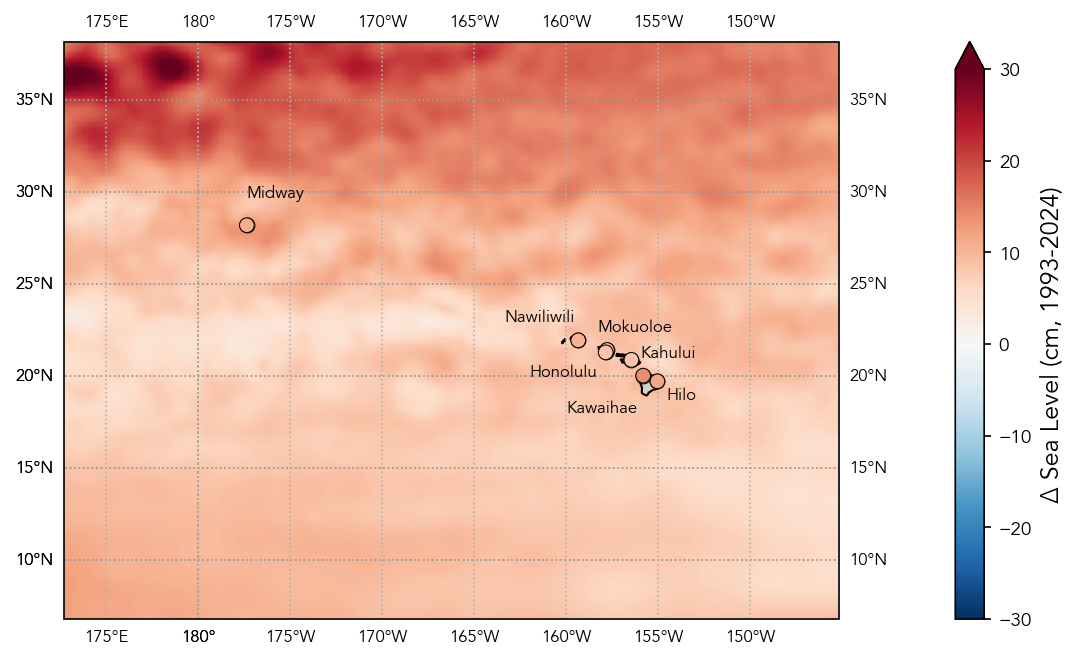

In [23]:
fig, ax, crs = pf.plot_map(vmin,vmax,cmap,xlims,ylims)

crs = ccrs.PlateCarree()
# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems*100
vmin, vmax = -30, 30
cmap = 'RdBu_r'

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, add_labels=False,
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2024)','pad': 0.1},
)
ax.scatter(rsl_daily['lon'], rsl_daily['lat'], transform=crs, s=50,
              c='white', linewidth=0.5, edgecolor='black',zorder=10)

#remove nan values from trend_mag_rsl
trend_mag_rsl = trend_mag_rsl.where(~np.isnan(trend_mag_rsl),drop = True)

ax.scatter(trend_mag_rsl['lon'], trend_mag_rsl['lat'], transform=crs, s=50, 
           c=100*trend_mag_rsl.values, vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)


# add text label for each station name in ds
station_names = rsl_daily.station_name.values
for i, station_name in enumerate(station_names):
    lon = rsl_daily['lon'][i].item() 
    lat = rsl_daily['lat'][i].item()

    # now we must space out the text
    if 'Hilo' in station_name:
        lon += 0.5
        lat -= 1
        station_name = 'Hilo'

    if 'Sand' in station_name:
        # lon += 1.5
        lat += 1.5
        station_name = 'Midway'

    if 'Nawiliwili' in station_name:
        lat += 1
        lon -= 4

    if 'Kahului' in station_name:
        lon =-156
        lat =21
        station_name = 'Kahului'

    if 'Mokuoloe' in station_name:
        lon -= 0.5
        lat += 1

    if 'Kawaihae' in station_name:
        lon =-160
        lat -= 2

    if 'Honolulu' in station_name:
        lon = -162
        lat = 20

    ax.text(lon, lat, station_name, transform=crs, fontsize=8, horizontalalignment='left')

# Add gridlines and ticks
latlondx = [5, 10]
lon_ticks = np.arange(-180, 181, latlondx[0])  # Every 20° from -180 to 180
lat_ticks = np.arange(-90, 91, latlondx[0])  # Every 10° from -90 to 90
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle=':')
gl.xlocator = plt.FixedLocator(lon_ticks)  # Set longitude tick locations
gl.ylocator = plt.FixedLocator(lat_ticks)  # Set latitude tick locations
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False, top=False)
ax.tick_params(axis='y', which='both', labelleft=False, left=False, right=False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)

glue("mag_fig", fig, display=False)

# # save the figure
output_file_path = output_dir / 'SL_magnitude_map_Hawaii.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


```{glue:figure} mag_fig
:name: "mag-fig"
Map of absolute and relative sea level change from the altimetry and tide gauge record near the {glue:text}`station_group` stations from {glue:text}`start_date_str` to {glue:text}`end_date_str`. 

[Download Image](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_magnitude_map_Hawaii.png) 
```


Now we'll make it interactive:

In [24]:
# Do the same plot but now make it interactive
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# --- Create a scatter_map plot ---


# 1. Prepare the dataframes for plotting
# Altimetry data (gridded)
trend_mag_cmems_cm_df = trend_mag_cmems_cm.to_dataframe(name='sla').reset_index()
trend_mag_cmems_cm_df = trend_mag_cmems_cm_df.rename(columns={'sla': 'Δ Sea Level (cm)'})

vmin = 0
vmax = trend_mag_cmems_cm_df['Δ Sea Level (cm)'].max()

# Tide gauge data
trend_mag_rsl_clean = trend_mag_rsl.where(~np.isnan(trend_mag_rsl), drop=True)
rsl_df = pd.DataFrame({
    'lat': trend_mag_rsl_clean['lat'].values,
    'lon': trend_mag_rsl_clean['lon'].values,
    'station_name': rsl_daily.station_name.sel(station_id=trend_mag_rsl_clean.station_id).values,
    'station_id': trend_mag_rsl_clean.station_id.values,
    'rsl_cm': 100 * trend_mag_rsl_clean.values,
    'asl_cm': 100 * trend_mag_asl.sel(station_id=trend_mag_rsl_clean.station_id).values
})
rsl_df['hover_text'] = rsl_df.apply(
    lambda row: f"{row['station_name']} ({row['station_id']})<br>ASL: {row['asl_cm']:.2f} cm<br>RSL: {row['rsl_cm']:.2f} cm",
    axis=1
)


# 2. Create the base map with altimetry data
fig = px.scatter_map(
    trend_mag_cmems_cm_df,
    lat="latitude",
    lon="longitude",
    color="Δ Sea Level (cm)",
    color_continuous_scale='Reds',
    range_color=(vmin, vmax),
    opacity=0.6,
    zoom = 3,
    title="Δ Sea Level: Altimetry vs Tide Gauges",
    hover_name=None,
    hover_data=None
)
# Explicitly disable hover for the base map layer
fig.data[0].hoverinfo = 'none'
fig.data[0].hovertemplate = None
# 3. Add the tide gauge data as two layers to create a border effect

# Add a layer for the black border
fig.add_trace(go.Scattermap(
    lat=rsl_df['lat'],
    lon=rsl_df['lon'],
    mode='markers',
    marker=go.scattermap.Marker(
        size=15,  # Slightly larger for the border
        color='black'
    ),
    hoverinfo='none',
    showlegend=False,
    name='Tide Gauge Border'
))

# Add the main colored marker layer on top
fig.add_trace(go.Scattermap(
    lat=rsl_df['lat'],
    lon=rsl_df['lon'],
    mode='markers',
    marker=go.scattermap.Marker(
        size=13,
        color=rsl_df['rsl_cm'],
        colorscale='Reds',
        cmin=vmin,
        cmax=vmax,
        showscale=False, # Colorbar is already shown by the main plot
    ),
    hoverinfo='text',
    text=rsl_df['hover_text'],
    name='Tide Gauge'
))

# 4. Update layout
fig.update_layout(
    height=300,
    width=500,
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=False,

    hoverlabel=dict(
        bgcolor="white",
        bordercolor="black",
        font=dict(
            family="Avenir, sans-serif",
            size=12,
            color="black"
        )
    ),
    coloraxis_colorbar=dict(
        title_side="right",
        title_font=dict(
            family="Avenir, sans-serif"
        )
    ),
    map_layers = [
        {
            "sourcetype": "geojson",
            # URL to a public GeoJSON file for coastlines
            "source": "https://geo.pacioos.hawaii.edu/geoserver/PACIOOS/hi_sohdop_all_shore/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=PACIOOS:hi_sohdop_all_shore&outputFormat=application/json",
            "type": "line",
            "color": "black",
            "line": {"width": 0.5},
        }
    ]
)

# Add a title



# Save as HTML for embedding
fig.write_html(output_dir / 'interactive_SL_trend.html')

# Display the interactive plot
fig.show()


(create-a-time-series-plot)=
### Create a Time series plot 
Finally we will combine both tide gauge and altimetry sources into a time series plot that includes both [Absolute](ASLtimeseries)  and [Relative](RSLtimeseries) Time Series.


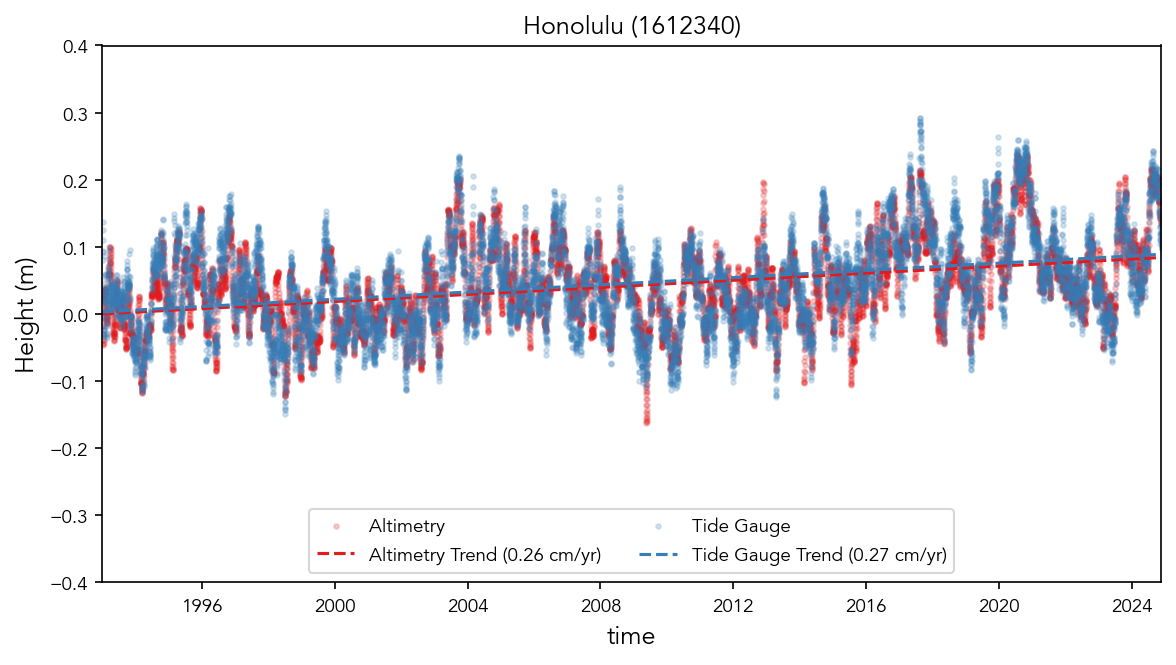

In [25]:
# Create a color palette
palette = sns.color_palette("Set1")

# find the station_ids that do not have nan trend_mag_rsl
station_ids = trend_mag_rsl.station_id.values

# Only for one station
i = 5
fig,ax = plt.subplots(1,1,figsize=(8,5))


# plot altimetry data
sla_tg.sla.sel(station_id=station_ids[i]).plot.scatter(ax = ax, x='time', label='Altimetry', color=palette[0], alpha=0.2, s=5)
trend_line_asl.sel(station_id=station_ids[i]).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(station_id=station_ids[i]):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--')
rsl_daily.rsl_anomaly.sel(station_id=station_ids[i]).plot.scatter(ax = ax, x='time', label='Tide Gauge', color=palette[1], alpha=0.2, s=5)
trend_line_rsl.sel(station_id=station_ids[i]).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(station_id=station_ids[i]):.2f} cm/yr)', 
                                                      color=palette[1], linestyle='--')
title = f'{rsl_daily.station_name.sel(station_id=station_ids[i]).values} ({station_ids[i]})'
ax.set_title(title)
ax.set_ylabel('Height (m)')   

# Set the y and x limits
ax.set_ylim([-.40, .40])
ax.set_xlim([start_date, end_date])
# Adjust overall figure aesthetics
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title



# Add a legend 
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0),ncol = 2)


glue('trend_fig_station', fig, display=False)
glue('station',title,display=False)

# # save the figure
figname = f'SL_magnitude_timeseries_{station_ids[i]}_Hawaii.png'
output_file_path = output_dir / figname
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')

```{glue:figure} trend_fig_station
:name: "trend_fig_station"

Absolute sea level trend (red) from altimetry, and relative sea level trend (blue) from the tide gauge record at the {glue:text}`station` tide gauge station from {glue:text}`start_date_str` to {glue:text}`end_date_str`.
```

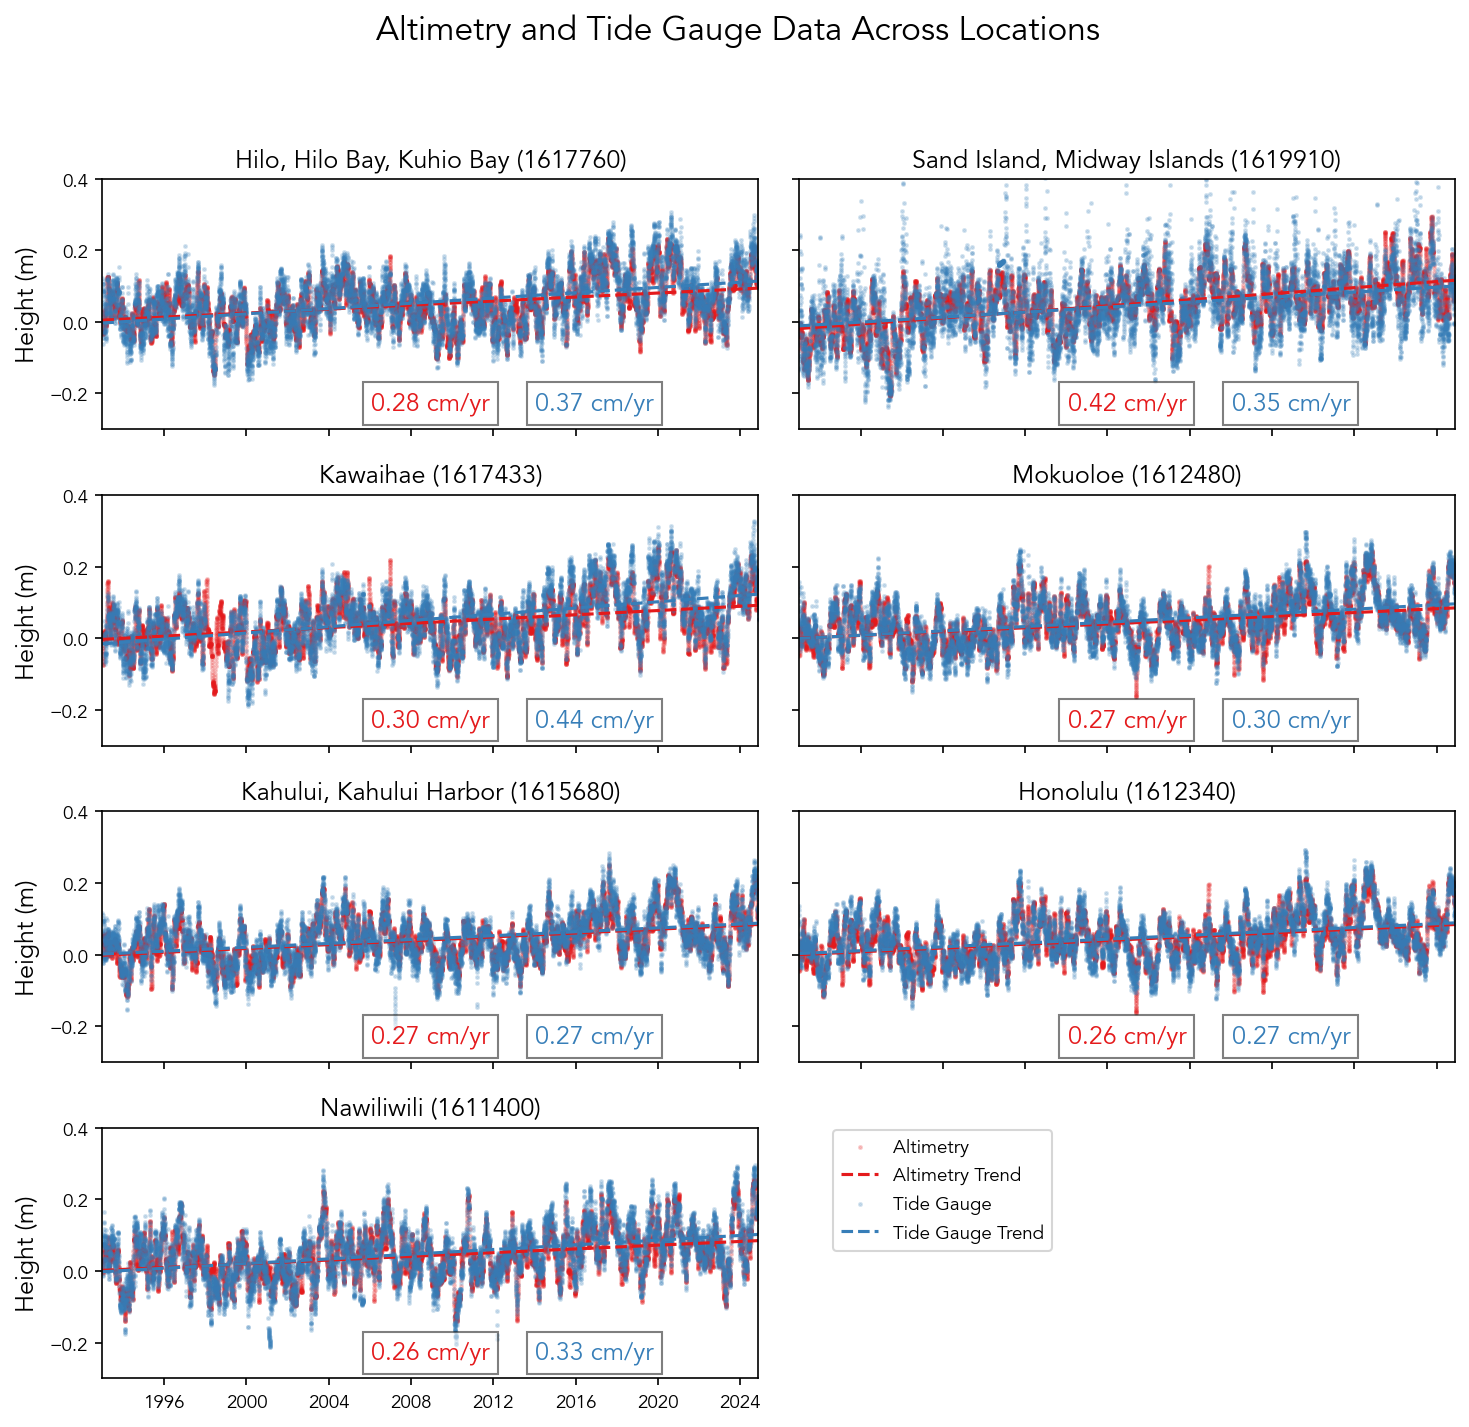

In [26]:
# Create a color palette
palette = sns.color_palette("Set1")



# find the station_ids that do not have nan trend_mag_rsl
station_ids = trend_mag_rsl.station_id.values

fig,axes = plt.subplots(4,2,figsize=(10,10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(len(station_ids)):
    ax = axes[i]
    # plot altimetry data
    sla_tg.sla.sel(station_id=station_ids[i]).plot.scatter(ax = ax, x='time', label='Altimetry', color=palette[0], alpha=0.2, s=2)
    trend_line_asl.sel(station_id=station_ids[i]).plot.line(ax = ax, x='time', label='Altimetry Trend', color=palette[0], linestyle='--')
    rsl_daily.rsl_anomaly.sel(station_id=station_ids[i]).plot.scatter(ax = ax, x='time', label='Tide Gauge', color=palette[1], alpha=0.2, s=2)
    trend_line_rsl.sel(station_id=station_ids[i]).plot.line(ax = ax, x='time', label='Tide Gauge Trend', color=palette[1], linestyle='--')
    title = f'{rsl_daily.station_name.sel(station_id=station_ids[i]).values} ({station_ids[i]})'
    ax.set_title(title)
    ax.set_ylabel('Height (m)')

    if i % 2 == 0:
        ax.set_ylabel('Height (m)')
    else:
        ax.set_ylabel('')

    if i < 10:
        ax.set_xlabel('')

    x_pos = 0.5
    y_pos = 0.05
    spacing = 0.25  # Adjust this value as needed for proper spacing

    # Create the first part of the text in red
    ax.text(x_pos, y_pos, f'{100*trend_rate_asl.sel(station_id=station_ids[i]):.2f} cm/yr', color=palette[0],
            verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))

    # Create the second part of the text in blue, separated by a fixed amount
    ax.text(x_pos + spacing, y_pos, f'{100*trend_rate_rsl.sel(station_id=station_ids[i]):.2f} cm/yr', color=palette[1],
            verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))
    


# Set the y and x limits
ax.set_ylim([-.30, .40])
ax.set_xlim([start_date, end_date])
# Adjust overall figure aesthetics
fig.suptitle('Altimetry and Tide Gauge Data Across Locations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
# Add a legend in the last subplot
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.75),ncol = 1)
# remove the last subplot
fig.delaxes(axes[-1])


glue("trend_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_timeseries_hawaii.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')



In [27]:
#what's the last data?
sla_tg.sla.time.max().values

np.datetime64('2024-11-19T00:00:00.000000000')

```{glue:figure} trend_fig
:name: "trend_fig"

Absolute sea level trend (red) from altimetry, and relative sea level trend (blue) from the tide gauge record at the {glue:text}`station_group` stations from {glue:text}`start_date_str` to {glue:text}`end_date_str`.
```
---

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```